In [2]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
import pandas as pd
import numpy as np

In [3]:
import fastai
fastai.__version__

'2.5.3'

In [4]:
import torch
import torch.nn as nn
torch.__version__

'1.9.1'

In [5]:
from fastai.vision.all import *

In [6]:
set_seed(999, reproducible=True)
BATCH_SIZE = 8                       #was 32

In [7]:
dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()

(#5) [Path('../input/petfinder-pawpularity-score/sample_submission.csv'),Path('../input/petfinder-pawpularity-score/train.csv'),Path('../input/petfinder-pawpularity-score/test.csv'),Path('../input/petfinder-pawpularity-score/test'),Path('../input/petfinder-pawpularity-score/train')]

In [8]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [9]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,../input/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,../input/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,../input/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,../input/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg


In [12]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'


In [13]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [18]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [19]:
def get_data(fold):

    train_df_f = pd.read_csv(f'../input/data-split-pawpularity/skf_split_train_5cv_fold{fold}.csv')
    train_df_f['is_valid'] = False
    valid_df_f = pd.read_csv(f'../input/data-split-pawpularity/skf_split_val_5cv_fold{fold}.csv')
    valid_df_f['is_valid'] = True
    
    train_df_f = train_df_f.append(valid_df_f)
    train_df_f['Id'] = train_df_f['img_path'].apply(lambda x: x.split('.')[-2].split('/')[-1])
    train_df_f['img_path'] = train_df_f['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
                               valid_col='is_valid', #
                               seed=999, #seed
                               fn_col='img_path', #filename/path is in the second column of the DataFrame
                               label_col='Pawpularity', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    return dls


In [20]:
#Valid Kfolder size
the_data = get_data(0)
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [21]:
!ls

__notebook__.ipynb


In [22]:
class cust_fastai_model(nn.Module):      
    def __init__(self, model_name='swin_large_patch4_window7_224'):
        super().__init__()
        self.swin = create_model(model_name, 
                           pretrained=True, num_classes=0)
        self.custom_head = nn.Linear(1536, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        
        self.custom_head3 = nn.Linear(256, 128)
        
        self.custom_head4 = nn.Linear(128, 64)
        
        self.custom_head5 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, image):
        emb = self.swin(image).squeeze(-1).squeeze(-1)
        x = self.custom_head(emb)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.custom_head3(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.custom_head4(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        out = self.custom_head5(x)
        return out

In [23]:
def get_learner(fold_num):
    data = get_data(fold_num)

    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

    learn = Learner(data, cust_fastai_model(), loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(func=petfinder_rmse)).to_fp16()
    
    return learn

In [24]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [25]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

SuggestedLRs(valley=0.0008780662901699543)

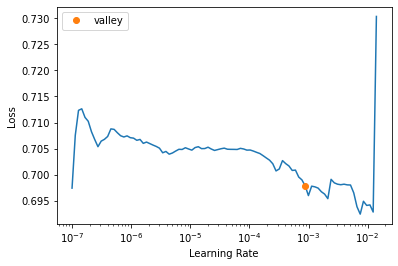

In [26]:
get_learner(fold_num=0).lr_find(end_lr=3e-2)             #was-2

In [27]:
import gc

Fold 0 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.664311,0.660825,20.224167,08:59
1,0.652318,0.644681,18.228909,09:01


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 20.224166870117188.
Better model found at epoch 1 with petfinder_rmse value: 18.22890853881836.


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.642141,0.642880,17.986019,09:01
1,0.638753,0.641250,17.767292,08:58
2,0.634770,0.641328,17.775314,08:59
3,0.634433,0.640597,17.679216,08:59
4,0.638389,0.641352,17.772068,09:01
5,0.621246,0.642121,17.849476,08:59


Better model found at epoch 0 with petfinder_rmse value: 17.986019134521484.
Better model found at epoch 1 with petfinder_rmse value: 17.767292022705078.
Better model found at epoch 3 with petfinder_rmse value: 17.679216384887695.
No improvement since epoch 3: early stopping


Fold 1 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.665564,0.660710,20.139837,09:01
1,0.650804,0.646709,18.409725,09:03


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 20.13983726501465.
Better model found at epoch 1 with petfinder_rmse value: 18.409725189208984.


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.648359,0.644855,18.175611,08:57
1,0.640812,0.643453,17.983368,08:55
2,0.643799,0.643064,17.939632,08:59
3,0.631977,0.646186,18.304371,08:58
4,0.628117,0.647124,18.422661,08:57


Better model found at epoch 0 with petfinder_rmse value: 18.17561149597168.
Better model found at epoch 1 with petfinder_rmse value: 17.983367919921875.
Better model found at epoch 2 with petfinder_rmse value: 17.939632415771484.
No improvement since epoch 2: early stopping


Fold 2 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.663935,0.661622,20.317421,08:55
1,0.652327,0.645800,18.385155,08:53


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 20.317420959472656.
Better model found at epoch 1 with petfinder_rmse value: 18.385154724121094.


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.640421,0.644328,18.178125,08:54
1,0.639744,0.643205,18.017942,08:57
2,0.637828,0.641002,17.737951,08:57
3,0.635920,0.640833,17.706814,08:57
4,0.633248,0.640655,17.672276,08:59
5,0.621491,0.641677,17.794476,09:01
6,0.612800,0.644740,18.165138,08:58


Better model found at epoch 0 with petfinder_rmse value: 18.178125381469727.
Better model found at epoch 1 with petfinder_rmse value: 18.017942428588867.
Better model found at epoch 2 with petfinder_rmse value: 17.737951278686523.
Better model found at epoch 3 with petfinder_rmse value: 17.70681381225586.
Better model found at epoch 4 with petfinder_rmse value: 17.67227554321289.
No improvement since epoch 4: early stopping


Fold 3 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.662836,0.661792,20.286760,08:59
1,0.648474,0.644268,18.106632,09:05


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 20.286760330200195.
Better model found at epoch 1 with petfinder_rmse value: 18.106632232666016.


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.640314,0.641759,17.768244,09:04
1,0.643823,0.640578,17.608200,09:03
2,0.643878,0.638734,17.370472,09:02
3,0.636493,0.640138,17.573002,09:03
4,0.631641,0.639992,17.539946,09:02


Better model found at epoch 0 with petfinder_rmse value: 17.76824378967285.
Better model found at epoch 1 with petfinder_rmse value: 17.608200073242188.
Better model found at epoch 2 with petfinder_rmse value: 17.370471954345703.
No improvement since epoch 2: early stopping


Fold 4 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.662411,0.661703,20.304022,09:02
1,0.655888,0.647123,18.513840,09:00


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 20.30402183532715.
Better model found at epoch 1 with petfinder_rmse value: 18.513839721679688.


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.647412,0.643594,18.063009,08:59
1,0.643814,0.643537,18.038511,09:01
2,0.642195,0.641918,17.828156,09:00
3,0.632648,0.642622,17.930416,08:56
4,0.627430,0.644432,18.145807,08:55


Better model found at epoch 0 with petfinder_rmse value: 18.06300926208496.
Better model found at epoch 1 with petfinder_rmse value: 18.038511276245117.
Better model found at epoch 2 with petfinder_rmse value: 17.828155517578125.
No improvement since epoch 2: early stopping


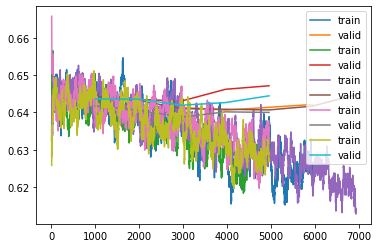

In [29]:
all_preds = []

for i in range(5):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=i)
    
    learn.fine_tune(10,  2e-5, freeze_epochs=2, cbs=[SaveModelCallback('petfinder_rmse', comp=np.less), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)] )
#   
    learn.recorder.plot_loss()

    learn = learn.to_fp32()
    
    learn.export(f'model_fold_{i}.pkl')
    
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    test_dl = dls.test_dl(test_df)
    
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    
    all_preds.append(preds)
    
    learn.export(f'model_fold_{i}_aftertest.pkl')
    
    del learn

    torch.cuda.empty_cache()

    gc.collect()

In [30]:
!ls ..

input  lib  src  working


In [31]:
all_preds

[tensor([[0.4140],
         [0.4172],
         [0.4127],
         [0.4144],
         [0.4132],
         [0.4118],
         [0.4176],
         [0.4172]]),
 tensor([[0.3396],
         [0.3388],
         [0.3329],
         [0.3390],
         [0.3359],
         [0.3392],
         [0.3446],
         [0.3380]]),
 tensor([[0.4112],
         [0.4104],
         [0.4124],
         [0.4136],
         [0.4089],
         [0.4114],
         [0.4125],
         [0.4086]]),
 tensor([[0.4172],
         [0.4209],
         [0.4168],
         [0.4173],
         [0.4199],
         [0.4104],
         [0.4163],
         [0.4237]]),
 tensor([[0.3822],
         [0.3939],
         [0.3782],
         [0.3797],
         [0.3851],
         [0.3797],
         [0.3983],
         [0.3849]])]

In [32]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

In [33]:
pd.read_csv('submission.csv').head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,39.282590
1,43a2262d7738e3d420d453815151079e,39.622967
2,4e429cead1848a298432a0acad014c9d,39.060920
3,80bc3ccafcc51b66303c2c263aa38486,39.280884
4,8f49844c382931444e68dffbe20228f4,39.258236
